In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

## Loading audio file

In [8]:
audio_path = '../Fifa-vocal-noise-rem-only.aac'
scale, sampling_rate = librosa.load(audio_path)

/tmp/ipykernel_12614/3590508323.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  scale, sampling_rate = librosa.load(audio_path)
/home/jitheesh/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


## Extracting Mel spectrogram

In [9]:
mel_spectrogram = librosa.feature.melspectrogram(y=scale, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

In [10]:
mel_spectrogram.shape

(10, 65066)

In [11]:
def display(mel_spectrogram):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(mel_spectrogram,
                            x_axis='time',
                            y_axis='mel',
                            sr=sampling_rate)
    plt.show()
    

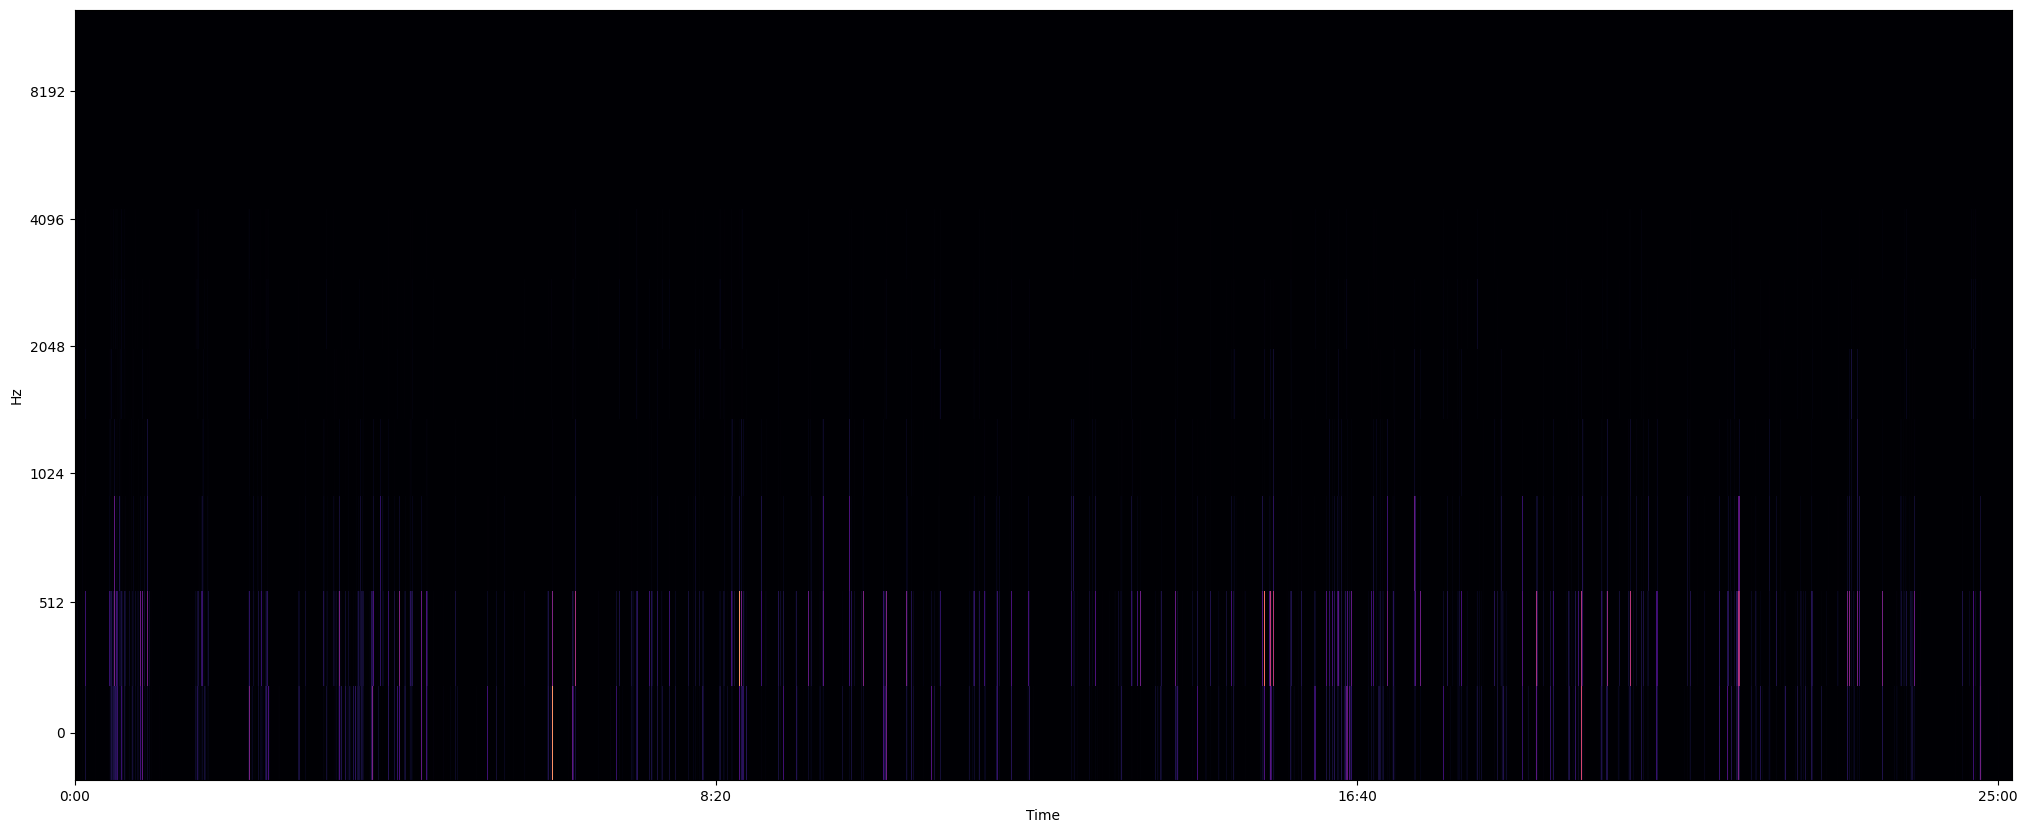

In [12]:
display(mel_spectrogram=mel_spectrogram)

In [13]:
log_mel_spectogram = librosa.power_to_db(mel_spectrogram)

In [14]:
log_mel_spectogram.shape

(10, 65066)

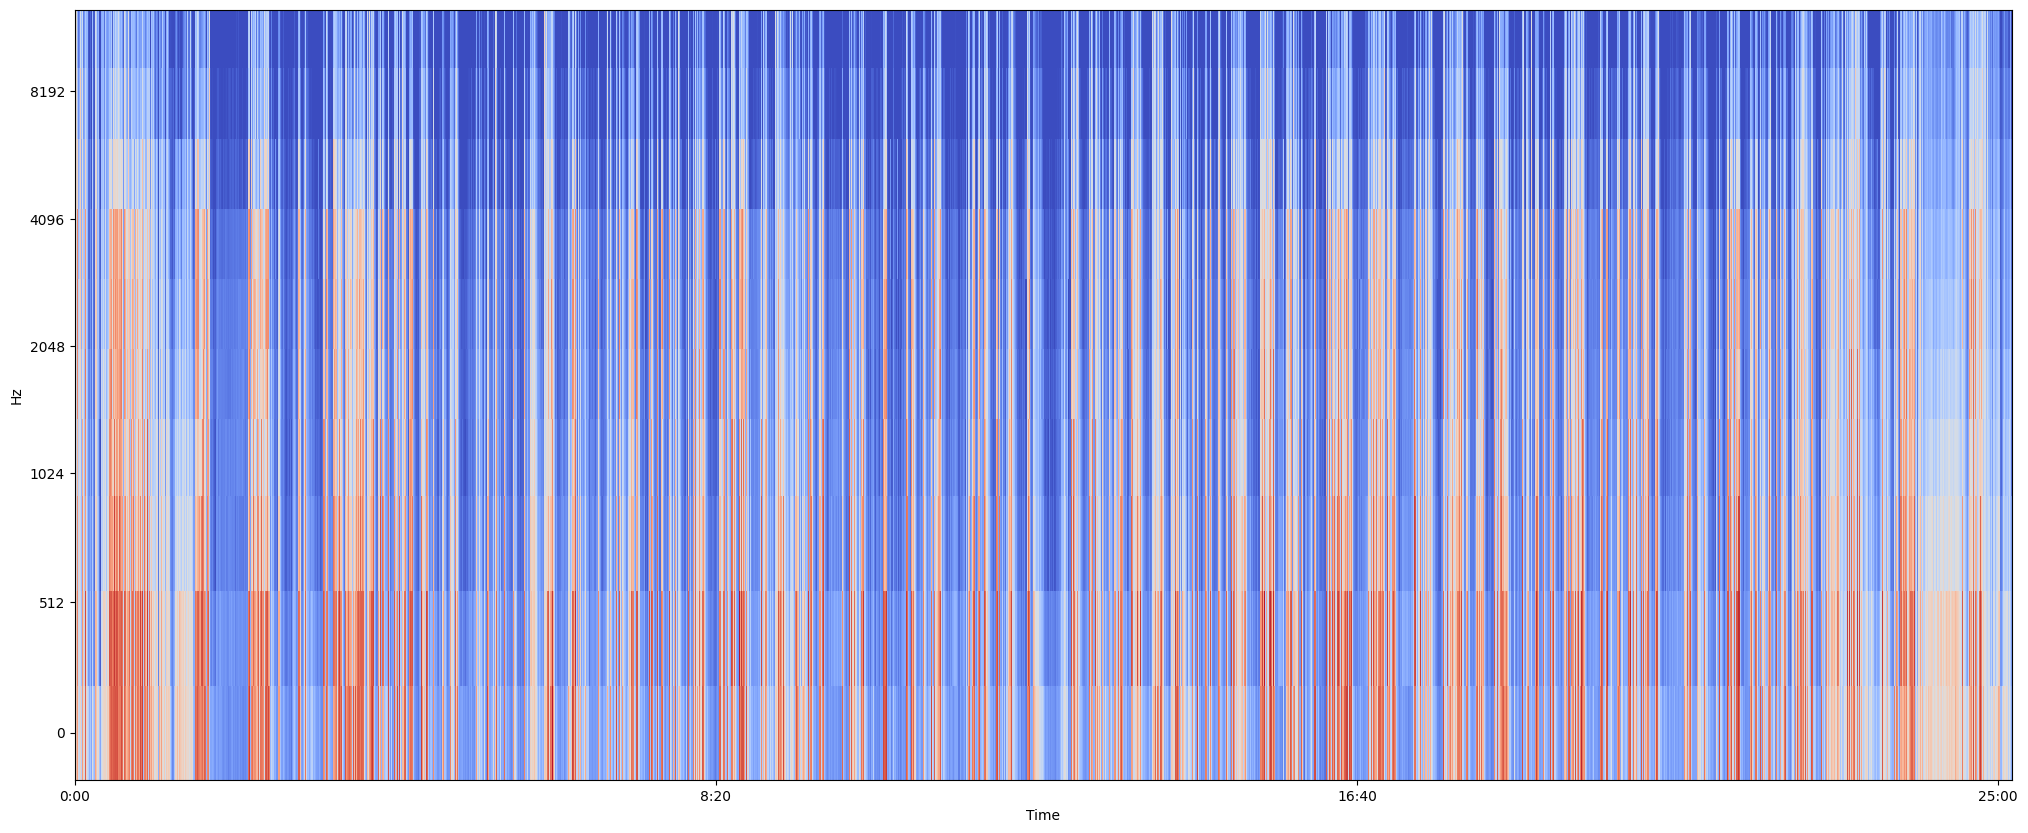

In [15]:
display(log_mel_spectogram)

## Mel spectrogram for each segment

### Calculate the total number of intervals

In [16]:
interval_length = 10
total_duration = len(scale) / sampling_rate
num_intervals = int(total_duration // interval_length)

### Calculate the Mel spectrogram for each interval

In [31]:
mel_spectrograms = list()
for interval in range(num_intervals):
    # Define the start and end index for the current interval
    start_index = interval * interval_length * sampling_rate
    end_index = (interval + 1) * interval_length * sampling_rate

    # Get the audio slice for the current interval
    interval_audio = scale[start_index:end_index]

    # Obtain the Mel spectrogram for the interval
    interval_mel_spec = librosa.feature.melspectrogram(y=interval_audio, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

    interval_log_mel_spec = librosa.power_to_db(interval_mel_spec)

    # Append the Mel spectrogram to the list
    mel_spectrograms.append(interval_log_mel_spec)

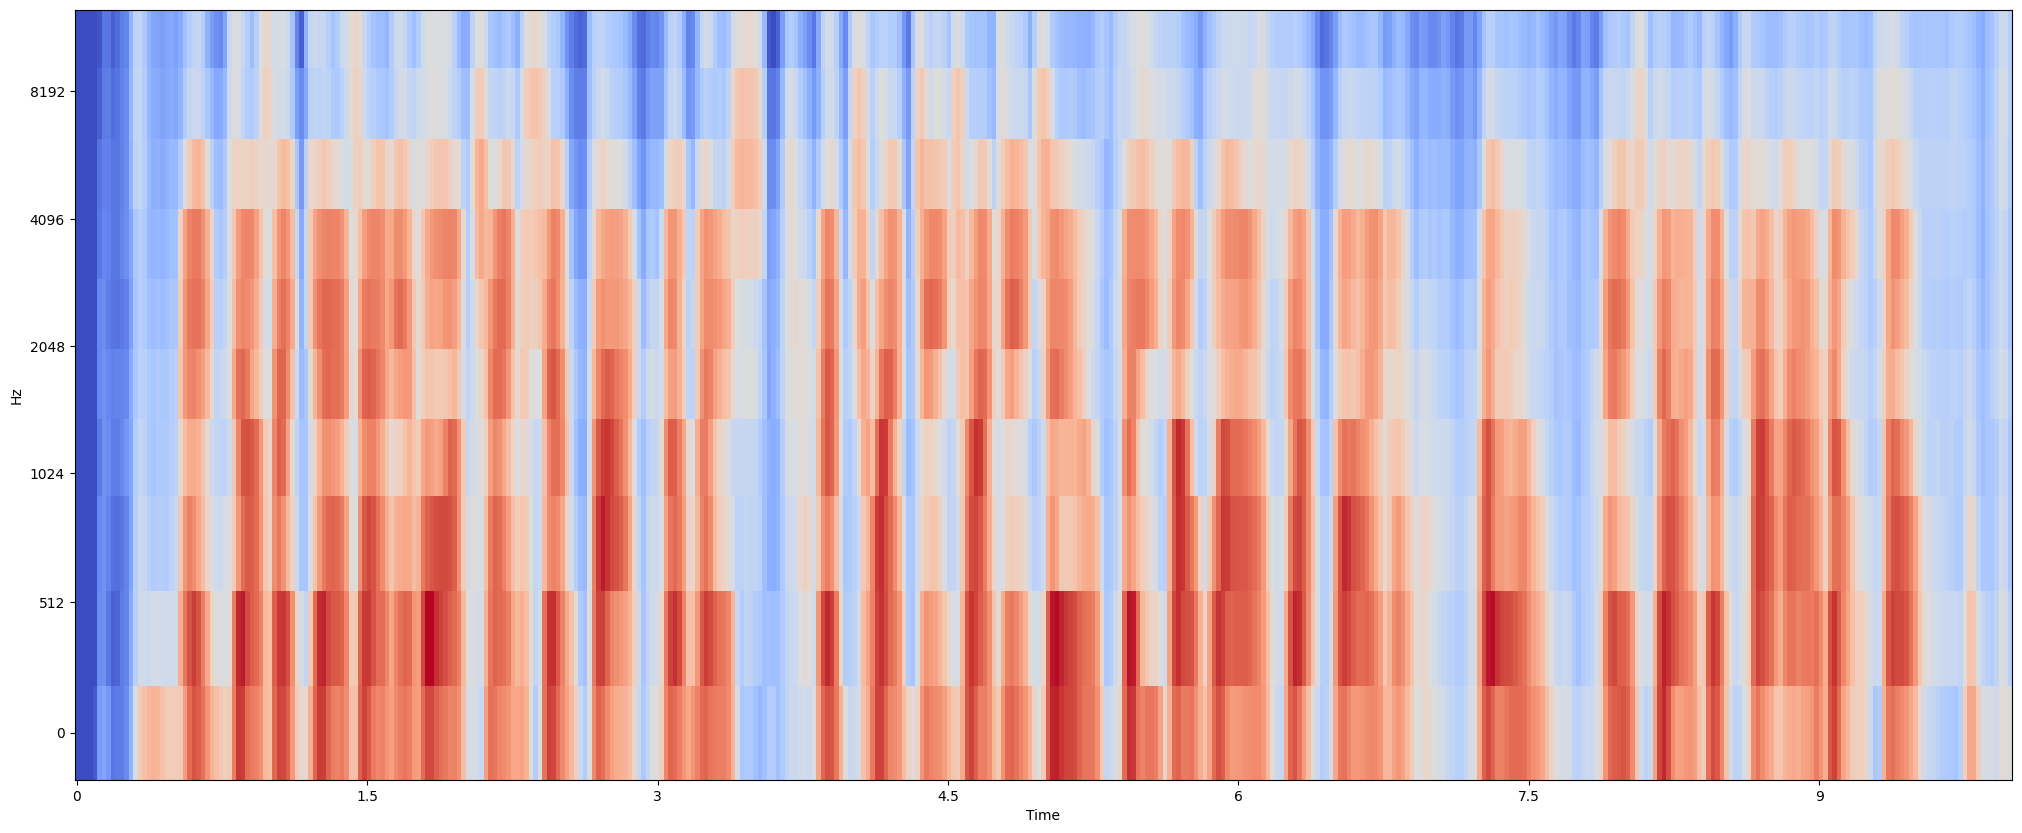

In [46]:
display(mel_spectrograms[0])